In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import sklearn
import matplotlib.pyplot as plt
from sklearn import preprocessing
import random
from scipy.spatial import distance
from sklearn import cluster
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
import datetime

## 2. Grouping songs together!

### 2.1 Getting your data!

In [3]:
echonest = pd.read_csv('echonest.csv')
features = pd.read_csv('features.csv')
tracks = pd.read_csv('tracks.csv')

In [12]:
print(echonest.shape)
print(features.shape)
print(tracks.shape)

(13129, 250)
(106574, 519)
(106574, 53)


In [13]:
# Merge the dataset in order to have information about echonest track (left merge - index of echonest)
# We merge with the key = 'track_id'
merged_df = pd.merge(pd.merge(echonest, features, on='track_id', how='left'), tracks, on='track_id', how='left')
# We store the merged dataset to avoid to compute it each time
merged_df.to_csv('merged_df.csv')

In [14]:
merged_df.describe()

,track_id,audio_features_acousticness,audio_features_danceability,audio_features_energy,audio_features_instrumentalness,audio_features_liveness,audio_features_speechiness,audio_features_tempo,audio_features_valence,metadata_artist_latitude,...,artist_id,artist_latitude,artist_longitude,track_bit_rate,track_comments,track_duration,track_favorites,track_interest,track_listens,track_number
count,13129.000000,1.312900e+04,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,9770.000000,...,13129.000000,8052.000000,8052.000000,13129.000000,13129.000000,13129.000000,13129.000000,1.312900e+04,13129.000000,13129.000000
mean,34031.058268,5.246876e-01,0.487290,0.537516,0.640536,0.187804,0.099174,123.080061,0.439761,39.961892,...,6303.865641,40.144635,-49.099826,248580.807068,0.044558,249.013558,4.310305,3.784447e+03,2147.068703,5.608500
std,28950.422182,3.837186e-01,0.190148,0.278049,0.361430,0.158051,0.137381,35.015137,0.276028,15.554275,...,4974.103114,15.603089,57.881761,63834.230395,0.494095,207.268166,20.884705,3.396744e+04,9434.471644,6.108004
min,2.000000,9.035000e-07,0.051307,0.000020,0.000000,0.025297,0.022324,12.753000,0.000010,-45.867100,...,1.000000,-43.532054,-123.114034,-1.000000,0.000000,18.000000,0.000000,6.300000e+01,12.000000,0.000000
25%,12986.000000,1.037726e-01,0.344759,0.321300,0.323466,0.101406,0.036932,95.967000,0.197321,37.784827,...,2203.000000,37.871166,-85.111004,192000.000000,0.000000,156.000000,0.000000,6.700000e+02,299.000000,2.000000
50%,28097.000000,5.739848e-01,0.485635,0.549113,0.838134,0.119002,0.049019,120.057000,0.417743,40.781400,...,5442.000000,40.714550,-73.950000,256000.000000,0.000000,214.000000,1.000000,1.351000e+03,694.000000,4.000000
75%,45021.000000,9.207270e-01,0.629094,0.776254,0.918244,0.211041,0.085452,145.318000,0.665575,47.254575,...,9288.000000,47.218371,-0.045680,320000.000000,0.000000,282.000000,4.000000,2.948000e+03,1714.000000,8.000000
max,124911.000000,9.957965e-01,0.968645,0.999964,0.998016,0.980330,0.966177,251.072000,0.999990,68.927500,...,20818.000000,65.201935,174.885971,448000.000000,37.000000,3033.000000,1482.000000,3.293557e+06,543252.000000,213.000000


In [92]:
# to avoid to merge each time
merged_df = pd.read_csv('merged_df.csv')
merged_df.shape

(13129, 821)

### 2.2 Choose your features (variables)! TO DO

In [93]:
#drop columns with too few values (less than the half)
#drop the columns with 'genre' in the name

col_dropped=[]
for col in merged_df.columns:
    nb_missed = merged_df[col].isna().sum() 
    n = merged_df.shape[0]
    if nb_missed > 7500 :
        col_dropped.append(col)
        merged_df.drop([col], axis = 1, inplace = True)
    
    if 'genre' in col :
        col_dropped.append(col)
        merged_df.drop([col], axis = 1, inplace = True)


In [94]:
#print dropped column to be sure to not drop a very relevant attribute
print(col_dropped)

['metadata_album_date', 'metadata_album_name', 'ranks_artist_discovery_rank', 'ranks_artist_familiarity_rank', 'ranks_artist_hotttnesss_rank', 'ranks_song_currency_rank', 'ranks_song_hotttnesss_rank', 'album_engineer', 'album_producer', 'artist_active_year_begin', 'artist_active_year_end', 'artist_associated_labels', 'artist_related_projects', 'artist_wikipedia_page', 'track_composer', 'track_date_recorded', 'track_genre_top', 'track_genres', 'track_genres_all', 'track_information', 'track_lyricist', 'track_publisher']


#### Encode the values

In [95]:
# for variables which represent dates we will use the datetime type and transform it in numerical values
res = []
for col in merged_df.columns:
    if ('date' in col) or ('year' in col):
        merged_df[col] = pd.to_numeric(pd.to_datetime(merged_df[col], format = "%Y-%m-%d"))


In [96]:
merged_df.info(verbose = 1) # we have only 3 types : int, float or object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13129 entries, 0 to 13128
Data columns (total 799 columns):
 #    Column                              Dtype  
---   ------                              -----  
 0    Unnamed: 0                          int64  
 1    track_id                            int64  
 2    audio_features_acousticness         float64
 3    audio_features_danceability         float64
 4    audio_features_energy               float64
 5    audio_features_instrumentalness     float64
 6    audio_features_liveness             float64
 7    audio_features_speechiness          float64
 8    audio_features_tempo                float64
 9    audio_features_valence              float64
 10   metadata_artist_latitude            float64
 11   metadata_artist_location            object 
 12   metadata_artist_longitude           float64
 13   metadata_artist_name                object 
 14   metadata_release                    object 
 15   social_features_artist_discovery  

In [97]:
# store and encode object values + store numerical value in two different DataFrame
encoded_df = pd.DataFrame()
num_df = pd.DataFrame()

for col in merged_df.columns:
    
    #columns with non-numeric values
    if merged_df[col].dtype == object :
        #replace missing values by 'None'
        merged_df[col].fillna("None", inplace = True)  
        le = preprocessing.LabelEncoder()
        encoded_df[col]= le.fit_transform(merged_df[col])
    
    #columns with numeric values
    else :
        #replace missing values by the mean of the column
        #if (merged_df[col].dtype == float) or (merged_df[col].dtype == int):
        merged_df[col].fillna(merged_df[col].mean(), inplace = True)
        num_df[col] = merged_df[col]
        

In [98]:
print('merged_df' , merged_df.shape)
print('encoded_df' , encoded_df.shape)
print('num_df' , num_df.shape)

merged_df (13129, 799)
encoded_df (13129, 19)
num_df (13129, 780)


#### Apply PCA only to numerical values

We apply the PCA with 68 components, in order to have at least 70% of the total variance (of the numerical part).

In [99]:
#normalize for ACP
X1 = num_df.to_numpy()
Z1 = preprocessing.StandardScaler().fit_transform(X1) # normalize

#pca = PCA(n_components=Z.shape[1])
pca = PCA(n_components = 68)
A = pca.fit_transform(Z1)

In [100]:
#print(pca.explained_variance_ratio_)
print("The partial variance is equal to :", np.cumsum(pca.explained_variance_ratio_)[-1])

The partial variance is equal to : 0.7002856651247683


#### Normalize the object dataset

In [101]:
X2 = encoded_df.to_numpy()
Z2 = preprocessing.StandardScaler().fit_transform(X2)

In [102]:
Z2.shape

(13129, 19)

In [103]:
A.shape

(13129, 68)

In [104]:
# final reducted matrix
Z = np.hstack((A, Z2))
Z.shape

(13129, 87)

### 2.3 Clustering!

#### Implement KMeans Algorithm with random initialization

In [105]:
def KMeans(X, k, max_it = 100):
    #choose randomly points of X to initialize our centroids
    ind_centroids = random.sample(range(len(X)),k)
    #initialization of the centroids
    centroids = X[ind_centroids, :]
    #init the associated cluster for each point
    previous_clusters = [np.full(len(X), -1)]
    clusters = np.full(len(X), -1)
    
    distances = np.array([np.linalg.norm(X - centroids[i], axis = 1) for i in range(k)]).T
    clusters = np.argmin(distances, axis = 1)
    count = 0
    while (clusters != previous_clusters[-1]).any() and (count <= max_it):
        previous_clusters.append(clusters)
        # update the centroids
        for j in range(k):
            centroids[j] = np.mean(X[clusters==j,:], axis=0)
        distances = np.array([np.linalg.norm(X - centroids[i], axis = 1) for i in range(k)]).T
        clusters = np.argmin(distances, axis = 1)
        count+=1
        
    return clusters, centroids, count

#### Test Kmeans algorithm

In [21]:
random.seed(0)
%time clusters, centroids, count = KMeans(Z, 3, max_it = 100)
# i dont understand why the algo running is longer for normalized values

Wall time: 938 ms


In [22]:
clusters

array([0, 0, 0, ..., 2, 0, 1], dtype=int64)

#### Method to find an optimal number of clusters
1. Elbow method

In [30]:
def compute_elbow(X, cluster_labels, centroids):
    C = np.array([centroids[k] for k in cluster_labels])
    dist = np.linalg.norm(X-C, axis = 1)
    S = np.sum(dist)
    return S

In [31]:
def elbow_method(X, k_min, k_max):
    inertia = []
    K = []
    for k in range(k_min, k_max + 1):
        cluster_labels, centroids, count  = KMeans(X,k)
        S = compute_elbow(X, cluster_labels, centroids)
        inertia.append(S)
        K.append(k)
        print(k)
    plt.plot(K, inertia)
    plt.show()
    return K, inertia

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


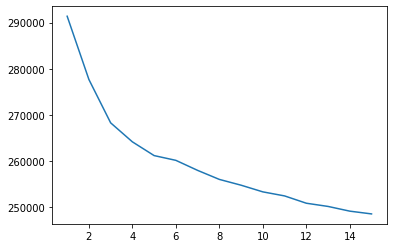

In [25]:
K, inertia = elbow_method(Z, 1, 15)

2. Silhouette score

In [106]:
def silhouette_score(X, cluster_labels, centroids):
    C = np.array([centroids[k] for k in cluster_labels])
    
    #Compute the average of distances between each point and its centroid
    dist = np.linalg.norm(X-C, axis = 1)
    intra_cluster = np.mean(dist)
    
    #Compute the average of distances between each centroid
    L=[]
    for i in range(len(centroids)) : 
        c1 = centroids[i]
        for j in range(i+1, len(centroids)) : # avoid to compute the distance twice
            c2 = centroids[j]
            if (c1 != c2).any() :
                L.append(np.linalg.norm(c1-c2))
    inter_cluster = np.mean(np.array(L))
    
    silhouette_score = (inter_cluster - intra_cluster) / max(intra_cluster, inter_cluster)
    return silhouette_score
    

In [107]:
def silhouette_method(X, k_min, k_max):
    silhouette_scores = []
    K = []
    for k in range(k_min, k_max + 1):
        cluster_labels, centroids, count  = KMeans(X,k)
        #S = silhouette_score(X, cluster_labels, centroids)
        S = sklearn.metrics.silhouette_score(X, cluster_labels)
        silhouette_scores.append(S)
        K.append(k)
        print(k)
    plt.plot(K, silhouette_scores)
    plt.show()
    return K, silhouette_scores

On Z, reduced data with ACP

2
3
4
5
6
7
8
9
10


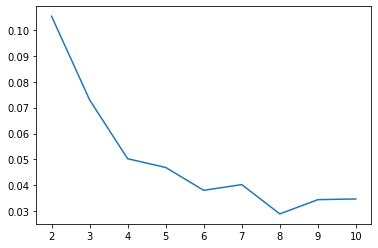

In [108]:
K, silhouette_scores = silhouette_method(Z, 2, 10)

**With the elbow method we can see where we have a shortage of the curve and choose the optimal number of clusters. Obsiouly, the silhouette does not seem to work with our dataset...** 

So finally, we choose **5 clusters** to work.


#### Clustering with KMeans ++

In [72]:
kmeans = cluster.KMeans(n_clusters=5, init = 'k-means++').fit(Z)

In [73]:
kmeans_plus_pred = kmeans.labels_

In [74]:
kmeans_random_pred = KMeans(Z, 5, max_it = 100)

In [75]:
print('Kmeans ++ :', kmeans_plus_pred[:100])
print('Kmeans hom:', kmeans_random_pred[0][:100])

Kmeans ++ : [0 0 0 4 0 2 3 3 3 4 2 3 2 4 1 2 4 4 4 4 2 4 4 4 4 2 4 1 3 3 0 3 3 3 1 1 3
 3 3 2 1 3 3 3 1 3 3 2 3 3 3 3 2 2 0 3 3 2 2 3 2 4 4 2 2 3 3 2 3 3 3 2 0 2
 3 0 3 3 3 0 3 0 3 3 3 2 2 0 0 3 3 3 3 4 2 3 0 3 3 3]
Kmeans hom: [0 1 1 2 1 0 4 4 4 2 0 4 0 2 4 0 2 2 0 2 0 2 2 2 2 0 2 3 4 3 1 4 4 4 3 3 4
 4 4 0 3 3 4 4 3 4 4 0 4 4 4 4 0 0 1 4 4 0 0 4 0 2 2 0 0 4 4 0 4 4 4 0 1 0
 4 1 4 4 4 1 4 1 4 4 4 0 0 1 1 4 4 4 4 0 0 4 1 4 4 4]


Markdown to store the result in case we run it again with a different initialization of Kmeans
```
Kmeans ++ : [0 0 0 4 0 2 3 3 3 4 2 3 2 4 1 2 4 4 4 4 2 4 4 4 4 2 4 1 3 3 0 3 3 3 1 1 3
 3 3 2 1 3 3 3 1 3 3 2 3 3 3 3 2 2 0 3 3 2 2 3 2 4 4 2 2 3 3 2 3 3 3 2 0 2
 3 0 3 3 3 0 3 0 3 3 3 2 2 0 0 3 3 3 3 4 2 3 0 3 3 3]
Kmeans hom: [0 1 1 2 1 0 4 4 4 2 0 4 0 2 4 0 2 2 0 2 0 2 2 2 2 0 2 3 4 3 1 4 4 4 3 3 4
 4 4 0 3 3 4 4 3 4 4 0 4 4 4 4 0 0 1 4 4 0 0 4 0 2 2 0 0 4 4 0 4 4 4 0 1 0
 4 1 4 4 4 1 4 1 4 4 4 0 0 1 1 4 4 4 4 0 0 4 1 4 4 4]
```

### Analyse the result and compare it

We compute the confusion matrix to show if the clusters obtained with the two methos are the same or almost the same.

In [76]:
# Confusion matrix 
KM_plus = []
for el in kmeans_plus_pred:
    KM_plus.append(el)
    
confusion_matrix(KM_plus, kmeans_random_pred[0])


array([[  23, 3095,    0,    0,    2],
       [   3,    0,    4,  911,   10],
       [4224,   10,    0,    0,   62],
       [   0,   13,    0,   22, 2592],
       [  76,    1, 2081,    0,    0]], dtype=int64)

With this matrix we can conclude that there are some little differences. 
```
array([[  23, 3095,    0,    0,    2],
       [   3,    0,    4,  911,   10],
       [4224,   10,    0,    0,   62],
       [   0,   13,    0,   22, 2592],
       [  76,    1, 2081,    0,    0]], dtype=int64)
```
The clusters found with the random initialization are quite the same as those found with Kmeans++. The differences are due to the initialization of the cluster's centers.


### 2.4 Analysing your results!

#### Choose relevant attributes
* 'track_language_code' --> Language
* 'track_duration' --> Duration
* 'track_date_created' --> Date
* 'metadata_artist_location'--> Country/Region/State
* 'artist_name'--> Artist

#### Numerical variables --> 4 categories 

In [110]:
merged_df_bis = pd.read_csv('merged_df.csv')

# for variables which represent dates we will use the datetime type
res = []
for col in merged_df_bis.columns:
    if ('date' in col) or ('year' in col):
        merged_df_bis[col] = pd.to_numeric(pd.to_datetime(merged_df_bis[col], format = "%Y-%m-%d"))


In [111]:
relevant_variables = merged_df_bis[['track_language_code', 'track_duration', 'track_date_created', 'metadata_artist_location', 'artist_name']]

In [112]:
relevant_variables.head()

,track_language_code,track_duration,track_date_created,metadata_artist_location,artist_name
0,en,168,1227664092000000000,"Georgia, US",AWOL
1,en,237,1227664094000000000,"Georgia, US",AWOL
2,en,206,1227664100000000000,"Georgia, US",AWOL
3,en,161,1227635346000000000,"Philadelphia, PA, US",Kurt Vile
4,en,207,1227663799000000000,"Georgia, US",AWOL


In [113]:
relevant_variables.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13129 entries, 0 to 13128
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   track_language_code       5823 non-null   object
 1   track_duration            13129 non-null  int64 
 2   track_date_created        13129 non-null  int64 
 3   metadata_artist_location  9770 non-null   object
 4   artist_name               13129 non-null  object
dtypes: int64(2), object(3)
memory usage: 513.0+ KB


We have two possibilities to split our numerical values in 4 categories :
- either we make categories with the same width, but we will have representation (i mean numbers of values in each categories) very different
- or we make categories with the same number of values, but the width of the categories will more or less big

**We chose to use categories with different width but with the same number of points to be more relevant.**

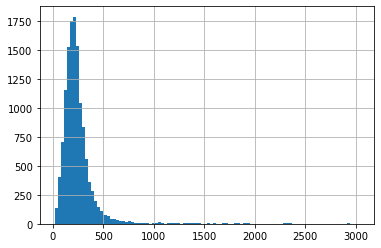

In [114]:
# 'track_duration' is integer/numerical variable so we have to make 4 categories 
relevant_variables['track_duration'].hist(bins = 100)
plt.show()


In [115]:
# 'track_date_created' is integer/numerical variable so we have to make 4 categories 
#relevant_variables['track_date_created'] = preprocessing.StandardScaler().fit_transform(relevant_variables[['track_date_created']].to_numpy())

col = relevant_variables['track_duration']

threshold_0 = col.min()
threshold_1 = sorted(col)[len(col)//4]
threshold_2 = sorted(col)[len(col)//4 * 2]
threshold_3 = sorted(col)[len(col)//4 * 3]
threshold_4 = col.max()

print("threshold_0 =", threshold_0)
print("threshold_1 =",threshold_1)
print("threshold_2 =",threshold_2)
print("threshold_3 =",threshold_3)
print("threshold_4 =",threshold_4)

relevant_variables['track_duration_categories'] = 0
relevant_variables['track_duration_categories'].loc[(threshold_0 <= col) & (col < threshold_1)] = 1
relevant_variables['track_duration_categories'].loc[(threshold_1 <= col) & (col < threshold_2)] = 2
relevant_variables['track_duration_categories'].loc[(threshold_2 <= col) & (col < threshold_3)] = 3
relevant_variables['track_duration_categories'].loc[(threshold_3 <= col) & (col <= threshold_4)] = 4

threshold_0 = 18
threshold_1 = 156
threshold_2 = 214
threshold_3 = 282
threshold_4 = 3033


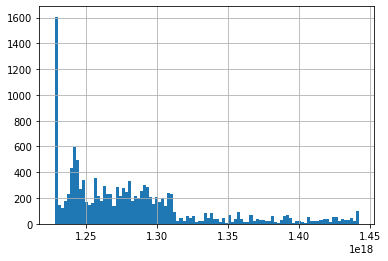

In [138]:
# 'track_date_created' is integer/numerical variable so we have to make 4 categories 
#relevant_variables['track_date_created'] = preprocessing.StandardScaler().fit_transform(relevant_variables[['track_date_created']].to_numpy())
relevant_variables['track_date_created'].hist(bins = 100)


In [116]:
# 'track_date_created' is integer/numerical variable so we have to make 4 categories 
#relevant_variables['track_date_created'] = preprocessing.StandardScaler().fit_transform(relevant_variables[['track_date_created']].to_numpy())

col = relevant_variables['track_date_created']

threshold_0 = col.min()
threshold_1 = sorted(col)[len(col)//4]
threshold_2 = sorted(col)[len(col)//4 * 2]
threshold_3 = sorted(col)[len(col)//4 * 3]
threshold_4 = col.max()

print(datetime.datetime.fromtimestamp(threshold_0 / 1e9))
print(datetime.datetime.fromtimestamp(threshold_1 / 1e9))
print(datetime.datetime.fromtimestamp(threshold_2 / 1e9))
print(datetime.datetime.fromtimestamp(threshold_3 / 1e9))
print(datetime.datetime.fromtimestamp(threshold_4 / 1e9))


relevant_variables['track_date_created_categories'] = 0
relevant_variables['track_date_created_categories'].loc[(threshold_0 <= col) & (col < threshold_1)] = 1
relevant_variables['track_date_created_categories'].loc[(threshold_1 <= col) & (col < threshold_2)] = 2
relevant_variables['track_date_created_categories'].loc[(threshold_2 <= col) & (col < threshold_3)] = 3
relevant_variables['track_date_created_categories'].loc[(threshold_3 <= col) & (col <= threshold_4)] = 4

2008-11-25 18:49:06
2009-05-15 18:55:43
2010-04-09 15:05:48
2011-03-06 07:20:57
2015-09-11 14:10:09


#### add the prediction of the clusters

In [168]:
merged_df_bis['pred_clusters'] = kmeans_random_pred[0]
relevant_variables['pred_clusters'] = kmeans_random_pred[0]
relevant_variables['Unnamed: 0']= merged_df_bis['Unnamed: 0']

#### Create the pivot tables

In [121]:
variables = ['track_language_code', 'track_duration_categories', 'track_date_created_categories', 'metadata_artist_location', 'artist_name'] # 
pivot_tables = []
for var in variables :
    table = pd.pivot_table(relevant_variables, index = var,  values= 'Unnamed: 0',
                           columns = ['pred_clusters'], aggfunc = 'count', fill_value=0)
    table = table.apply(lambda col : col/sum(col)*100).round(2)
    pivot_tables.append((var, table))
    

In [122]:
for i in range(len(variables)):
    print('Pivot Tables of the variables :', pivot_tables[i][0], '\n')
    print(pivot_tables[i][1], '\n\n\n')

Pivot Tables of the variables : track_language_code 

pred_clusters            0      1      2     3      4
track_language_code                                  
ar                    0.00   0.08   0.00   0.0   0.34
bm                    0.00   0.00   0.00   0.0   0.09
cs                    0.05   0.00   0.11   0.0   0.00
de                    0.16   0.00   0.00   0.0   0.09
el                    0.05   0.00   0.42   0.0   0.00
en                   95.61  93.88  96.50  99.8  96.15
es                    2.09   3.33   1.80   0.2   1.03
fi                    0.00   0.00   0.00   0.0   0.26
fr                    0.05   1.24   0.00   0.0   0.34
it                    0.21   0.23   0.11   0.0   0.43
ja                    0.00   0.23   0.00   0.0   0.00
ko                    0.00   0.00   0.11   0.0   0.00
pt                    0.26   0.93   0.11   0.0   0.68
ru                    0.42   0.08   0.21   0.0   0.00
sr                    0.21   0.00   0.21   0.0   0.00
sw                    0.16  

#### Analysis of tables 

##### Pivot Tables of the variables : track_language_code 
    
With this pivot table which shows the link between the language of the songs, we can tell that :

- English songs (en) represent a great majority of songs in each clusters
- The **cluster n°3** is represented with almost only **english songs**- en (99.8 %)
- Some languages are in the only one cluster : for example :
    - "bm" "fi" in clusters 4,
    - "ja" (japanese) in cluster 1,
    - "ko" in cluster 3
    
  So it means that the songs of **those language are easy to classify**.

Finally, the language of a song can be a very relevant indicators to choose the clusters, except for english song because there is to many songs in this languages to differentiate it. 
    

##### Pivot Tables of the variables : track_duration_categories 

We divided this attributes in four categories. The duration of the songs increases with the number of the category.
We can tell that :
- In the cluster 2 the duration tends to be shorter. Indeed, almost 45% the songs of this clusters have a duration in the first category, the shortest (less than 156s). Also for cluster 3, the music are "short" : 69% of songs under 214s. 
- In contrary, in the clusters 1 and 4 the duration tends to be longer. Indeed, almost 60% for cluster 1 and 62% for cluster 4 of the songs have a duration in the categories 3 and 4, the longest (more than 214s)
- For cluster 0, the duration is better distributed.


##### Pivot Tables of the variables : track_date_created_categories 

We divided this attributes in four categories. The date of creation of the songs increases with the number of the category.
We sould note that there is a lot of None-value for this attributes. 
We can tell that :
- In cluster 0, the songs seem to have more often one of oldest or most recent date of creation of the dataset, before May 200ç and after March 2011.
- In the cluster 1, it is more in the middle of date of creation (categories 2 and 3)
- In the cluster 2, the songs seem to have more often one of oldest or most recent date of creation of the dataset. 
- In the cluster 3, it is more in the category 2 (between May 2009 and April 2010)
- In cluster 4, the date of creation is better distributed.


##### Pivot Tables of the variables : metadata_artist_location 

In this table, it is more difficult to analyse something because there are too many different categories/location. However, one can nevertheless observe that most of the time a location is only represented in only one or two clusters, but it often for little city. In contrary, for big city it is more scattered. It means that the city in which the song was created is relevant to chose the cluster most of the time.

##### Pivot Tables of the variables : artist_name 

For artist name, it is quite the same as artist_location. Indeed, most of the time the artist is only represented in only one (or two but less) clusters.
Moreover, the representation of an artist in one cluster depends also on the number of songs he created. We can say that an artist is often attached to one cluster, maybe due to the genre of the artist.


#### Of courses all of this analysis would be quite different if we run again our Kmeans algorithm because the initialization would be different, the clusters' labels and the pivot tables. 


#### 2.4.6. Compare the obtained clusters to the reality genre

In [172]:
merged_df_bis[["track_genre_top", "track_genres", "track_genres_all"]]

,track_genre_top,track_genres,track_genres_all
0,Hip-Hop,[21],[21]
1,Hip-Hop,[21],[21]
2,Hip-Hop,[21],[21]
3,Pop,[10],[10]
4,Hip-Hop,[21],[21]
...,...,...,...
13124,NaN,"[286, 542]","[542, 21, 286, 15]"
13125,NaN,"[286, 542]","[542, 21, 286, 15]"
13126,NaN,"[286, 542]","[542, 21, 286, 15]"
13127,NaN,"[286, 542]","[542, 21, 286, 15]"


In [174]:
table = pd.pivot_table(merged_df_bis, index = 'track_genre_top',  values= 'Unnamed: 0',
                           columns = ['pred_clusters'], aggfunc = 'count', fill_value=0)
print(table, '\n\n')
table = table.apply(lambda col : col/sum(col)*100).round(2)
print(table)

pred_clusters           0     1     2    3    4
track_genre_top                                
Blues                  20     7     0    2   37
Classical               9     3     3  169   81
Electronic            414  1123   296   42  295
Experimental            6     2     2    2    5
Folk                  218    22    42  101  491
Hip-Hop               191   590    90    1   38
Instrumental           28    10     8    6   32
International          49    16    17    6   45
Jazz                   48    25    19   18  131
Old-Time / Historic     5     1     3  344    4
Pop                   118    62    40    4  122
Rock                 2024   214  1171   24  459 


pred_clusters            0      1      2      3      4
track_genre_top                                       
Blues                 0.64   0.34   0.00   0.28   2.13
Classical             0.29   0.14   0.18  23.50   4.66
Electronic           13.23  54.12  17.50   5.84  16.95
Experimental          0.19   0.10   0.12   0.28   

##### Pivot Tables of the variables : track_genre_top

To compare the obtained clusters to the reality genre, we compute the pivot table (numbers and percentages) between clusters and the variable **"track_genre_top"** which represents the genre the most representative for each song. However, we can note that the variables **"track_genres_all"** shows that one music can belongs to several genres.

- cluster 0 : Rock 65%, Electronic 13%, Folk 7%, Hip-Hop 6%
- cluster 1 : Electronic 54%, Hip Hop 28%, Rock 10%
- cluster 2 : Rock 69%, Electronic 17%
- cluster 3 : Old-Time / Historic 47%, Classical 23%, Folk 14.05% 
- cluster 4 : Folk 28%, Rock 26%, Electronic 17% 

Rock is often represented in the cluster, except cluster 3, but it is due to the fact that there many more songs of rock in the dataset than the others genres. 

We can see also that each genre has often one cluster in which it is more represented.
- Blues --> 4   
- Classical --> 3
- Electronic --> 1
- Experimental --> None
- Folk --> 4
- Hip-Hop --> 1
- Instrumental --> 0 and 4
- International --> 0 and 4
- Jazz --> 4
- Old-Time / Historic --> 3
- Pop --> 0 and 4
- Rock --> 0 and 2

#### Of courses all of this analysis would be quite different if we run again our Kmeans algorithm because the initialization would be different, the clusters' labels and the pivot tables. 

#### 2.4.7 KMeans ++ Analysis

In [16]:
df = pd.merge(features, tracks, on='track_id', how='left')

In [17]:
#drop columns with too few values (almost the half)
col_dropped=[]
for col in df.columns:
    nb_missed = df[col].isna().sum() 
    n = df.shape[0]
    if nb_missed > 50000 :
        print(col)
        col_dropped.append(col)
        df.drop([col], axis = 1, inplace = True)
    else :
        if 'genre' in col :
            col_dropped.append(col)
            df.drop([col], axis = 1, inplace = True)
        
# for variables which represent dates we will use the datetime type
res = []
for col in df.columns:
    if ('date' in col) or ('year' in col):
        df[col] = pd.to_numeric(pd.to_datetime(df[col], format = "%Y-%m-%d %H:%M:%S"))
        
# store and encode object values + store numerical value in two different DataFrame
encoded_df2 = pd.DataFrame()
num_df2 = pd.DataFrame()

for col in df.columns:
    
    #columns with non-numeric values
    if df[col].dtype == object :
        #replace missing values by 'None'
        df[col].fillna("None", inplace = True)  
        le = preprocessing.LabelEncoder()
        encoded_df2[col]= le.fit_transform(df[col])
    
    #columns with numeric values
    else :
        #replace missing values by the mean of the column
        df[col].fillna(df[col].mean(), inplace = True)
        num_df2[col] = df[col]

album_engineer
album_producer
artist_active_year_begin
artist_active_year_end
artist_associated_labels
artist_latitude
artist_longitude
artist_members
artist_related_projects
artist_wikipedia_page
track_composer
track_date_recorded
track_genre_top
track_information
track_language_code
track_lyricist
track_publisher


C:\Users\aurel\Downloads\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


We apply the PCA with **53 components**, in order to have at least 70% of the total variance (of the numerical part).

In [26]:
#normalize for ACP
X1 = num_df2.to_numpy()
Z1 = preprocessing.StandardScaler().fit_transform(X1) # normalize

pca = PCA(n_components=53)
A = pca.fit_transform(Z1)

In [27]:
print("The partial variance is equal to :", np.cumsum(pca.explained_variance_ratio_)[-1])

The partial variance is equal to : 0.7002386426036356


In [28]:
X2 = encoded_df2.to_numpy()
Z2 = preprocessing.StandardScaler().fit_transform(X2)

# final reducted matrix
Z2 = np.hstack((A, Z2))
Z2.shape

(106574, 67)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


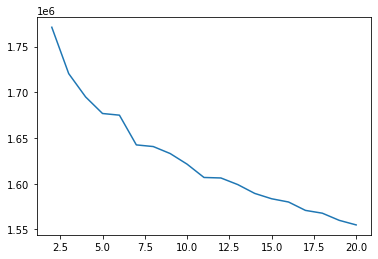

In [76]:
K, inertia = elbow_method(Z2, 2, 20)

In [80]:
def elbow_method2(X, k_min, k_max):
    inertia = []
    K = []
    for k in range(k_min, k_max + 1):
        KMEANS = cluster.KMeans(n_clusters=k, init = 'k-means++').fit(X)
        cluster_labels, centroids  = KMEANS.labels_, KMEANS.cluster_centers_
        inertia.append(KMEANS.inertia_)
        K.append(k)
        print(k)
    plt.plot(K, inertia)
    plt.show()
    return K, inertia



2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


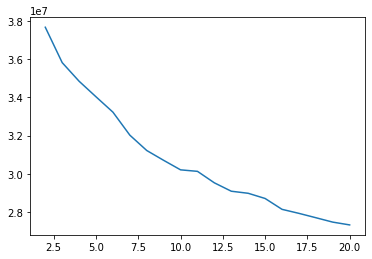

In [86]:
K2, inertia2 = elbow_method2(Z2, 2, 20)

We chose to keep 7 clusters as optimal number even if the curve break is less obvious than previously.

#### Choose relevant attributes - quite the same as previously

* 'track_language_code' --> Language
* 'track_duration' --> Duration
* 'track_date_created' --> Date
* 'artist_location'--> Country/Region/State      
    - We choose "artist_location" instead of "metadata_artist_location" previously because it was a variable of echonest
* 'artist_name'--> Artist

In [44]:
df_bis = pd.merge(features, tracks, on='track_id', how='left')

# for variables which represent dates we will use the datetime type
res = []
for col in df_bis.columns:
    if ('date' in col) or ('year' in col):
        df_bis[col] = pd.to_numeric(pd.to_datetime(df_bis[col], format = "%Y-%m-%d"))


In [45]:
relevant_variables2 = df_bis[['track_language_code', 'track_duration', 'track_date_created', 'artist_location', 'artist_name']]

**To split our numerical values in 4 categories :
We chose to use categories with different width but with the same number of points to be more relevant.**

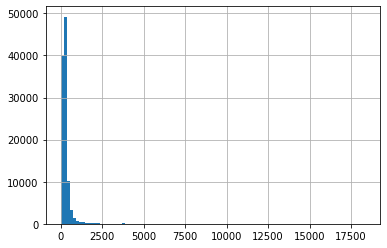

In [47]:
# 'track_duration' is integer/numerical variable so we have to make 4 categories 
relevant_variables2['track_duration'].hist(bins = 100)
plt.show()


In [48]:
# 'track_date_created' is integer/numerical variable so we have to make 4 categories 
#relevant_variables['track_date_created'] = preprocessing.StandardScaler().fit_transform(relevant_variables[['track_date_created']].to_numpy())

col = relevant_variables2['track_duration']

threshold_0 = col.min()
threshold_1 = sorted(col)[len(col)//4]
threshold_2 = sorted(col)[len(col)//4 * 2]
threshold_3 = sorted(col)[len(col)//4 * 3]
threshold_4 = col.max()

print("threshold_0 =", threshold_0)
print("threshold_1 =",threshold_1)
print("threshold_2 =",threshold_2)
print("threshold_3 =",threshold_3)
print("threshold_4 =",threshold_4)

relevant_variables2['track_duration_categories'] = 0
relevant_variables2['track_duration_categories'].loc[(threshold_0 <= col) & (col < threshold_1)] = 1
relevant_variables2['track_duration_categories'].loc[(threshold_1 <= col) & (col < threshold_2)] = 2
relevant_variables2['track_duration_categories'].loc[(threshold_2 <= col) & (col < threshold_3)] = 3
relevant_variables2['track_duration_categories'].loc[(threshold_3 <= col) & (col <= threshold_4)] = 4

threshold_0 = 0
threshold_1 = 149
threshold_2 = 216
threshold_3 = 305
threshold_4 = 18350


C:\Users\aurel\Downloads\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\aurel\Downloads\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


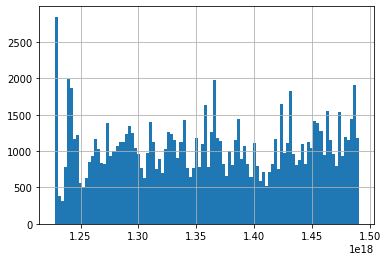

In [50]:
# 'track_date_created' is integer/numerical variable so we have to make 4 categories 
relevant_variables2['track_date_created'].hist(bins = 100)


In [87]:
# 'track_date_created' is integer/numerical variable so we have to make 4 categories 
#relevant_variables['track_date_created'] = preprocessing.StandardScaler().fit_transform(relevant_variables[['track_date_created']].to_numpy())

col = relevant_variables2['track_date_created']

threshold_0 = col.min()
threshold_1 = sorted(col)[len(col)//4]
threshold_2 = sorted(col)[len(col)//4 * 2]
threshold_3 = sorted(col)[len(col)//4 * 3]
threshold_4 = col.max()

print(datetime.datetime.fromtimestamp(threshold_0 / 1e9))
print(datetime.datetime.fromtimestamp(threshold_1 / 1e9))
print(datetime.datetime.fromtimestamp(threshold_2 / 1e9))
print(datetime.datetime.fromtimestamp(threshold_3 / 1e9))
print(datetime.datetime.fromtimestamp(threshold_4 / 1e9))


relevant_variables2['track_date_created_categories'] = 0
relevant_variables2['track_date_created_categories'].loc[(threshold_0 <= col) & (col < threshold_1)] = 1
relevant_variables2['track_date_created_categories'].loc[(threshold_1 <= col) & (col < threshold_2)] = 2
relevant_variables2['track_date_created_categories'].loc[(threshold_2 <= col) & (col < threshold_3)] = 3
relevant_variables2['track_date_created_categories'].loc[(threshold_3 <= col) & (col <= threshold_4)] = 4

2008-11-25 18:49:06
2010-12-15 19:23:48
2013-02-23 02:33:41
2015-05-12 13:36:21
2017-03-30 17:23:39


#### add the prediction of the clusters

In [55]:
kmeans_plus_labels = cluster.KMeans(n_clusters=7, init = 'k-means++').fit(Z2).labels_

In [56]:
kmeans_plus_labels

array([0, 0, 0, ..., 4, 4, 4])

In [67]:
df_bis['pred_clusters'] = kmeans_plus_labels
relevant_variables2['pred_clusters'] = kmeans_plus_labels
relevant_variables2['track_id']= df_bis['track_id']

#### Create the pivot tables

In [68]:
variables = ['track_language_code', 'track_duration_categories', 'track_date_created_categories', 'artist_location', 'artist_name'] # 
pivot_tables = []
for var in variables :
    table = pd.pivot_table(relevant_variables2, index = var,  values= 'track_id',
                           columns = ['pred_clusters'], aggfunc = 'count', fill_value=0)
    table = table.apply(lambda col : col/sum(col)*100).round(2)
    pivot_tables.append((var, table))
    

In [69]:
for i in range(len(variables)):
    print('Pivot Tables of the variables :', pivot_tables[i][0], '\n')
    print(pivot_tables[i][1], '\n\n\n')

Pivot Tables of the variables : track_language_code 

pred_clusters            0      1      2      3      4      5      6
track_language_code                                                 
ar                    0.03    0.0   0.00   0.00   0.02   0.15   0.23
az                    0.00    0.0   0.00   0.00   0.00   0.00   0.06
bg                    0.00    0.0   0.00   0.00   0.00   0.44   0.03
bm                    0.00    0.0   0.00   0.00   0.00   0.00   0.03
cs                    0.00    0.0   0.00   0.00   0.09   0.07   0.00
de                    0.20    0.0   0.43   0.17   0.07   2.12   0.61
ee                    0.00    0.0   0.00   0.00   0.15   0.00   0.00
el                    0.00    0.0   0.00   0.17   0.07   0.00   0.09
en                   93.53  100.0  94.26  97.96  96.23  91.89  95.38
es                    2.36    0.0   1.23   0.00   1.34   0.73   0.93
eu                    0.00    0.0   0.00   0.00   0.00   0.00   0.03
fi                    0.03    0.0   0.00   0.00  

### Compared to the previous exercise, we have some close results

##### Pivot Table of the variable : track_language_code 
    
- English songs (en) represent a great majority of songs in each clusters **as previously**
- Cluster 1 is only composed of english songs (100%)
- Some languages are in the only one cluster 
    
  So it means that the songs of **those language are rather easy to classify**.
  

##### Pivot Table of the variable : track_duration_categories 

As we saw previously, in each cluster the distributions of the duration of songs are different. Some clusters tend to have shorter songs than others. For example, here clusters 0 and 2 tend to have longer songs than cluster 1 and 3, while others have distrubtion more uniform...


##### Pivot Table of the variable : track_date_created_categories 

For this table, the cluster 1 is obviously composed of older songs than the other or at least have more "old songs".
Moreover, clusters 0 and 4, for example, have more older songs than clusters 2, 3 and 5 but 6 is more distributed.  

SO there are differences of date distribution between the clusters as we saw inthe previous exercise


##### Pivot Tables of the variables : artist_location  and  artist_name 

For these variables, it is more difficult to conclude. Indeed, there are too many different locations and singers to see well the trends for each clusters. However, we can still see that one artist is often attached to only one cluster while for the location it is less obvious...

In [71]:
table = pd.pivot_table(df_bis, index = 'track_genre_top',  values= 'track_id',
                           columns = ['pred_clusters'], aggfunc = 'count', fill_value=0)
print(table)

pred_clusters           0     2    3     4     5     6
track_genre_top                                       
Blues                  21    16    0    16    17    40
Classical              25    26    1    15   618   545
Country                35    23    2    66    11    57
Easy Listening         13     3    0     1     3     4
Electronic           3758  2051  448  1814   570   731
Experimental         2451  1303  951  2585  1218  2100
Folk                  212   268   30   245   510  1538
Hip-Hop              1952   685   46   738    58    73
Instrumental          181   321   84   283   426   784
International         416   116    9   187   234   427
Jazz                  133    72    5    66   160   135
Old-Time / Historic     0     2    0     7    43   502
Pop                   533   352  164   582   206   495
Rock                 1199  1793  601  8602   240  1747
Soul-RnB               85    27    0    48    10     5
Spoken                260    16    3    57    27    60


##### Pivot Tables of the variables : track_genre_top

To compare the obtained clusters to the reality genre, we compute the pivot table (numbers and percentages) between clusters and the variable **"track_genre_top"**

Here, contrary to previously, we can see that the genres are less well grouped in a single cluster, except Old-Time / Historic Classical, Spoken...

**So we can conclude that it is not always better to have more observations/samples if the numbers of features is too low or if these features are not relevant enough. Indeed, we had best results with our Kmeans with fewer rows (13K) but more features. So it could be better to have fewer observations with more feature or rather more relevant features. I must add that it would be also better to have non-numerical features with fewer different categories, I mean if we have too many different categories for a feature, it will not give us much information as can we saw with 'location' and 'artist' variables.**


## 3. Algorithmic questions

In [10]:
def pairs(A,s):
    res=[]
    for i in range(len(A)):
        for j in range(i+1, len(A)):
            if A[i]+A[j] == s:
                res.append((A[i],A[j]))
    return res

In [11]:
A = [7, -2, 8, 2, 6, 4, -7, 2, 1, 3, -3] 
s = 4

print(*pairs(A,s))

(7, -3) (-2, 6) (2, 2) (1, 3)
